# Import modules

In [1]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager

# Other
from tqdm import tqdm
import os
from pathlib import Path
from os import listdir

# Graphics
from matplotlib import pyplot as plt
import seaborn as sns

# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, convert_to_grayscale, get_dataset_name
from csv_dataloader import get_train_test_data
from math import floor

# Generate Dataset

In [2]:
create_dataset = 0
if create_dataset:
    generate_csv(win_size=9, dump_to_file=50000, step=1)

# NN Model

In [3]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        self.hid_n = 400
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.hid_n * 2),
            # nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n * 3),
            nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            
            nn.Linear(self.hid_n * 3, self.hid_n * 3),
            # nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            nn.Linear(self.hid_n * 3, self.hid_n * 3),
            nn.BatchNorm1d(self.hid_n * 3),
            nn.ReLU(),
            
            nn.Linear(self.hid_n * 3, self.hid_n * 2),
            # nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.out_len),
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

## Define constants

In [4]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "imgs_with_noise" 

p_filtered_images = p_main_data / "filtered_imgs"

p_genuine_images = p_main_data / "gray_images"

# Hyperparameters 
learning_rate = 0.005
num_epoches = 2
batch_size = 256

# Dataset
win_size = 5
_step = 20

dataset_name = get_dataset_name(win_size, _step, p_scv_folder) #r"W5_S1_L3696640.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{dataset_name = }\n{device = }")

dataset_name = 'W5_S20_L9000.csv'
device = device(type='cuda')


## Initialize model

In [5]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
losses = []
losses_append = losses.append

valid_losses = []
valid_losses_append = valid_losses.append

for epoch in range(num_epoches):
    model.train()
    train_loader, test_loader = get_train_test_data(scv_folder=p_scv_folder, dataset_name=dataset_name, batch_size=batch_size, train_size=0.9)
    for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
        # Data on cuda
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        if batch_ind % 3 == 0:
            losses_append(loss.item())
        # Backprop
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
        optimizer.zero_grad()
    model.eval()
    with torch.no_grad():
        for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            # Forward
            scores = model(data) # Equal to model.forward(data)
            loss = criterion(scores, targets)
            valid_losses_append(loss.item())



31it [00:02, 13.33it/s]
5it [00:00, 108.76it/s]
31it [00:00, 60.79it/s]
5it [00:00, 104.23it/s]


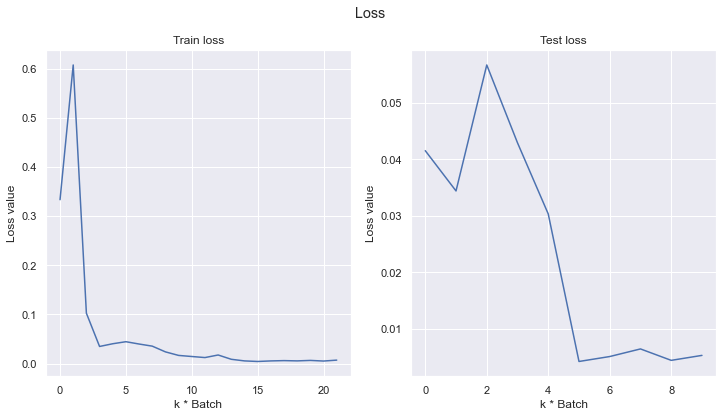

In [8]:
sns.set()
fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Loss')

ax_train.set_title("Train loss")
ax_test.set_title("Test loss")

ax_train.set_ylabel('Loss value')
ax_test.set_ylabel('Loss value')

ax_train.set_xlabel("k * Batch")
ax_test.set_xlabel("k * Batch")

sns.lineplot(data=losses, ax=ax_train, )
sns.lineplot(data=valid_losses, ax=ax_test)

plt.show()
sns.set()

In [ ]:
path_to_model = p_models / dataset_name
torch.save(model, path_to_model)

# Check NN works

In [ ]:
list_images = listdir(p_noised_imgs)
for img_name in list_images:
    filtering_image(model, p_filtered_images, p_noised_imgs, img_name, win_size, device)

In [ ]:
check_ssim(p_filtered_images, p_genuine_images)

In [ ]:
model_name = "also_good_modelW9_S1.csv"
load_model = 0
if load_model:
    model = torch.load(p_models / model_name)
    

In [ ]:
p_real_imgs = p_main_data / "real_images"
p_raw_image = p_real_imgs / "raw"
p_out_imgs = p_real_imgs / "filtered"

list_images = listdir(p_raw_image)
for img_name in list_images:
    filtering_image(model, p_out_imgs, p_raw_image, img_name, win_size, device)